# Nicholas Cruz
# February 26, 2023
# Recognizing Handwritten Digits with k-Nearest-Neighbor Classification Algorithm

## Introduction

This report will utilize the k-nearest-neighbor algorithm developed in class to classify handwritten digits. We will then discuss interesting things I noticed while developing this model.

## Retrieving MNIST Data

We will pull the MNIST data from the web then convert the images into numpy arrays. For brevity, I use 99% of the dataset for training and 1% for testing.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
import requests
import gzip

from sklearn.model_selection import train_test_split

In [3]:
# function to pull data from web and store in global vars
def get_MNIST():
    mnist_url = "http://yann.lecun.com/exdb/mnist/"
    img_file = "train-images-idx3-ubyte.gz"
    labels_file = "train-labels-idx1-ubyte.gz"

    for fname in [img_file, labels_file]:
        if Path(fname).is_file() :
            print(f"Found: {fname}")
            continue
        print(f"Downloading: {fname}")
        r = requests.get(mnist_url + fname)
        with open(fname, 'wb') as foo:
            foo.write(r.content)   

    global images
    global labels
    with gzip.open(img_file, 'rb') as foo:
        f = foo.read()
    images = np.array([b for b in f[16:]]).reshape(-1, 28,28)
    with gzip.open("train-labels-idx1-ubyte.gz", 'rb') as foo:
        f = foo.read()
    labels = np.array([b for b in f[8:]])
    
get_MNIST()

Downloading: train-images-idx3-ubyte.gz
Downloading: train-labels-idx1-ubyte.gz


In [4]:
# split data into train and test
image_train, image_test, label_train, label_test = train_test_split(images, labels, test_size=0.01, random_state=42)

## Training the Model

To develop the classifier, we must simply find the label of the element which lies closest to the test point. 

We will use the `find_kNN` function as a helper, which finds `k` amount of nearest neighbors to the test point based on Euclidean distance.

The function `knn_classifier` will use the helper to obtain the `k` nearest image arrays to the test image `x`. From that array, we will select the furthest neighbor as our final prediction (there are other ways of making this selection).

In [5]:
# helper function to find kNN
def find_kNN(X,p,k):
    dist = np.linalg.norm(X-p,axis=1) # get all euclidean distances
    return np.argsort(dist)[:k] # sort neighbor indices

# classifier
def knn_classifier(training_images, training_labels, x, n):
    # reshape appropriately 
    training_images=training_images.reshape((training_images.shape[0], 28*28))
    x=x.reshape((28*28))
    
    knn=find_kNN(training_images,x,n)
    label_index=knn[-1] # obtain furthest neighbor index
    
    return (training_labels[label_index], knn) # return furthest neighbor and neighbor array

In [6]:
# visualization helper

def visualize_6_digits(ind,k=5):
    fig, axs = plt.subplots(2, 3,)
    
    axs[0,0].imshow(image_test[ind[0]],cmap='Greys')
    axs[0,0].set_title(f'Prediction: {knn_classifier(image_train,label_train,image_test[0],k)[0]}')
    
    axs[0,1].imshow(image_test[ind[1]],cmap='Greys')
    axs[0,1].set_title(f'Prediction: {knn_classifier(image_train,label_train,image_test[1],k)[0]}')
    
    axs[0,2].imshow(image_test[ind[2]],cmap='Greys')
    axs[0,2].set_title(f'Prediction: {knn_classifier(image_train,label_train,image_test[2],k)[0]}')
    
    axs[1,0].imshow(image_test[ind[3]],cmap='Greys')
    axs[1,0].set_title(f'Prediction: {knn_classifier(image_train,label_train,image_test[3],k)[0]}')
    
    axs[1,1].imshow(image_test[ind[4]],cmap='Greys')
    axs[1,1].set_title(f'Prediction: {knn_classifier(image_train,label_train,image_test[4],k)[0]}')
    
    axs[1,2].imshow(image_test[ind[5]],cmap='Greys')
    axs[1,2].set_title(f'Prediction: {knn_classifier(image_train,label_train,image_test[5],k)[0]}')
    
    fig.suptitle(f'kNN Classifier with k={k}')
    
    plt.tight_layout()

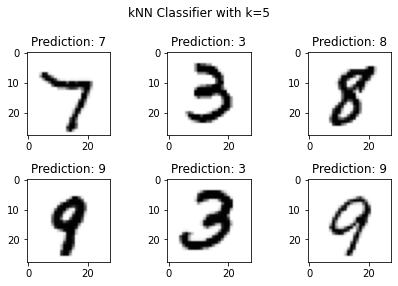

In [7]:
visualize_6_digits((0,1,2,3,4,5))

## Testing the Model

In this section we will test each image of the testing set and observe how well the `knn_classifier` function performs.

In [8]:
k=5

pass_count = 0

for i in range(len(image_test)):
    test_image = image_test[i]
    expected = label_test[i]
    
    actual = knn_classifier(image_train,label_train,test_image,k)[0]
    
    if actual == expected:
        pass_count+=1
        
print(f'This classifier passed {pass_count} tests out of {len(image_test)}, with {pass_count/len(image_test)*100}% accuracy.')

This classifier passed 573 tests out of 600, with 95.5% accuracy.


## Analyzing Accuracy

### The problem with small training sets

The most interesting thing I noticed when developing the `knn_classifier` was that, if the training dataset was small enough, the function would make inaccurate predictions even on the training data. Because the function uses the last element of the `argsort` array to make its prediction, it's possible that the last element is not the accurate prediction when the training data is small. 

For instance, take the training set `training=[1,1,4,2,0]` with `k=3`. If we have a test point `test=0`, then the sorted k-length array of its neighbors would be `[0,1,1]`. Thus, the prediction would be 1, not 0, which is inaccurate.

This phenomenon can be easily demonstrated with the MNIST data.

The prediction is 8 with neighbors [1 1 8 2 8]


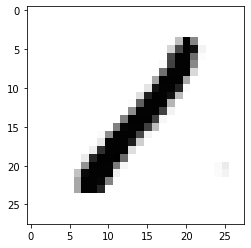

In [9]:
small_training_images=image_train[:20] # small slice of img data
small_training_labels=label_train[:20] # small slice of label data

k=5

test_image=small_training_images[1] # this image is a 1
plt.imshow(test_image, cmap='Greys')

prediction, neighbors = knn_classifier(small_training_images,small_training_labels,test_image,k)

print(f'The prediction is {prediction} with neighbors {small_training_labels[neighbors]}')

This number is clearly not 8, however the prediction was made based on the limited training data. We will see a higher accuracy rate by:
1. Decreasing `k`'s value.
2. Use more training data.

Further exploration into this model might be to find an optimal `k` value given a training set with certain size and variance.

## Conclusion

I found that the k-nearest-neighbor algorithm was suprisingly powerful in classifying handwritten digits. While there is much room for optimization, I am amazed by the accuracy and simplicity of this model.

## References

- MTH448 Weekly Jupyter Notebooks and Exercises
- [NumPy Documentation](https://numpy.org/doc/stable/index.html) 